# Modeling: Classification 

## Introduction

### Review of Classification Models

- Supervised machine learning algorithm
- The inputs are called *features*
- The output is called the *label*, *target*, or *dependent variable*
- Provides a prediction of a categorical label.
- Binary classification - two categories
- Multiclass classification - three or more categories

### Spark MLlib + Classification

- Spark MLlib provides several classification algorithms:
    * Logistic Regression (with Elastic Net, Lasso, and Ridge Regression)
    * Decision Tree
    * Random Forest
    * Gradient-Boosted Trees
    * Multilayer Perceptron (Neural Network)
    * Linear Support Vector Machine (SVM)
    * Naive Bayes

- Spark MLlib also provides a meta-algorithm for constructing multiclass classification models from binary classification models:
    * One-vs-Rest

- Spark MLlib requires the features to be assembled into a vector of doubles column.

## Lesson

### Scenario


### Setup

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pyspark.sql.functions import when, col, lower, upper, round, regexp_extract, count, countDistinct
from pyspark.sql.types import DoubleType

- Start a SparkSession

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.\
    master("local[*]").\
    appName("classification").\
    getOrCreate()

- Load the data

In [3]:
# cases
case_data = "data/case.csv"
df_case = spark.read.csv(case_data, header=True)

dept_data = "data/dept.csv"
df_dept = spark.read.csv(dept_data, header=True)

In [4]:
df = df_case.join(df_dept, "dept_division", "left_outer")

In [5]:
df.printSchema()
# df.show(5)

root
 |-- dept_division: string (nullable = true)
 |-- case_id: string (nullable = true)
 |-- case_opened_date: string (nullable = true)
 |-- case_closed_date: string (nullable = true)
 |-- SLA_due_date: string (nullable = true)
 |-- case_late: string (nullable = true)
 |-- num_days_late: string (nullable = true)
 |-- case_closed: string (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- SLA_days: string (nullable = true)
 |-- case_status: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: string (nullable = true)
 |-- dept_name: string (nullable = true)
 |-- standardized_dept_name: string (nullable = true)
 |-- dept_subject_to_SLA: string (nullable = true)



- normalize the text data

In [6]:
df = df.select(lower(col('dept_division')).alias('dept_division'), 
          lower(col('service_request_type')).alias('request_type'),
          lower(col('dept_name')).alias('dept_name'),
          lower(col('standardized_dept_name')).alias('dept_name_std'),
          (col('case_closed')=='YES').alias('case_closed'),
          when(col('case_late')=='YES', 1).otherwise(0).alias('target'),
          (col('dept_subject_to_SLA')=='YES').alias('dept_w_SLA'),
          round(col('num_days_late').cast(DoubleType()), 2).alias('days_late'),
          round(col('SLA_days').cast(DoubleType()), 2).alias('SLA_days'),
          regexp_extract(col('request_address'),"(\d{5})$", 1).\
               alias("request_address_zip")
         )

- I probably don't want to use both dept_name and dept_name_std...so let's look at unique values to see which is more cleaned up.  

In [7]:
df.select(countDistinct('dept_division'), 
          countDistinct('dept_name'),
          countDistinct('dept_name_std'),
          countDistinct('request_type')).\
          toPandas().transpose()

,0
count(DISTINCT dept_division),39
count(DISTINCT dept_name),9
count(DISTINCT dept_name_std),8
count(DISTINCT request_type),334


- I will use the standardized department name, given it has fewer distinct values, making me think it is more *standardized*...go figure!

In [8]:
df = df.drop('dept_name')

### Preprocess the modeling data

- Use the [SQLTransformer](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.SQLTransformer) to filter out rows that don't apply:

In [9]:
from pyspark.ml.feature import SQLTransformer

filterer = SQLTransformer(
    statement="SELECT * FROM __THIS__ WHERE \
           dept_w_SLA AND case_closed")

filtered = filterer.transform(df)

- `__THIS__` is a placeholder for the DataFrame passed into the `transform` method.

### Generate label

- We can treat `target_var` as a continuous numerical label or an ordered categorical label:

In [10]:
filtered.\
    groupBy('target').\
    count().orderBy('target').show()

+------+------+
|target| count|
+------+------+
|     0|735612|
|     1| 87978|
+------+------+



In [11]:
filtered.printSchema()

root
 |-- dept_division: string (nullable = true)
 |-- request_type: string (nullable = true)
 |-- dept_name_std: string (nullable = true)
 |-- case_closed: boolean (nullable = true)
 |-- target: integer (nullable = false)
 |-- dept_w_SLA: boolean (nullable = true)
 |-- days_late: double (nullable = true)
 |-- SLA_days: double (nullable = true)
 |-- request_address_zip: string (nullable = true)



### Extract, transform, and select features

- Create function to explore features:

In [12]:
def explore(df, target, cont1, cont2):
    from pyspark.sql.functions import count, mean, corr
    aggregated = df.groupby(target).agg(count(cont1), 
                                      mean(cont1),
                                      mean(cont2),
                                      corr(cont1,cont2)
                                     ).orderBy(target)
    aggregated.show()

In [13]:
explore(filtered, 'target','SLA_days','days_late')

+------+---------------+------------------+------------------+-------------------------+
|target|count(SLA_days)|     avg(SLA_days)|    avg(days_late)|corr(SLA_days, days_late)|
+------+---------------+------------------+------------------+-------------------------+
|     0|         735612| 64.44108282626593|-58.57142732854374|      -0.9976264528231221|
|     1|          87978|14.202606674395911|22.111734751869783|      0.24758733973851202|
+------+---------------+------------------+------------------+-------------------------+



- Takeaway:  the cases that are past their due date seem to have shorter SLA's

In [14]:
sample_pdf = filtered.select('SLA_days', 'days_late', 'target'). \
  sample(False, 0.20, 12345). \
  toPandas()

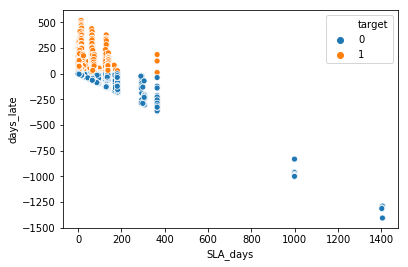

In [15]:
sns.scatterplot(x=sample_pdf.SLA_days, 
                y=sample_pdf.days_late,
                hue=sample_pdf.target
               )

plt.show()

In [16]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="dept_name_std", outputCol="dept_name_std_ix")
indexer_model = indexer.fit(filtered)
list(enumerate(indexer_model.labels))
indexed = indexer_model.transform(filtered)
indexed.select("dept_name_std", "dept_name_std_ix").show(5)

+--------------------+----------------+
|       dept_name_std|dept_name_std_ix|
+--------------------+----------------+
|animal care services|             2.0|
|trans & cap impro...|             3.0|
|trans & cap impro...|             3.0|
|dsd/code enforcement|             0.0|
|animal care services|             2.0|
+--------------------+----------------+
only showing top 5 rows



- Then we use [OneHotEncoder](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.OneHotEncoder) to generate a set of dummy variables:

In [17]:
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCol="dept_name_std_ix", outputCol="dept_name_std_cd")
encoded = encoder.transform(indexed)
encoded.select("dept_name_std", "dept_name_std_ix", "dept_name_std_cd").show(5)

+--------------------+----------------+----------------+
|       dept_name_std|dept_name_std_ix|dept_name_std_cd|
+--------------------+----------------+----------------+
|animal care services|             2.0|   (6,[2],[1.0])|
|trans & cap impro...|             3.0|   (6,[3],[1.0])|
|trans & cap impro...|             3.0|   (6,[3],[1.0])|
|dsd/code enforcement|             0.0|   (6,[0],[1.0])|
|animal care services|             2.0|   (6,[2],[1.0])|
+--------------------+----------------+----------------+
only showing top 5 rows



- `cat_var1_cd` is stored as a `SparseVector`.

- Now we can (manually) select our features and label:

In [18]:
selected = encoded.select("SLA_days", "dept_name_std_cd", "target")
features = ["SLA_days", "dept_name_std_cd"]

- The machine learning algorithms in Spark MLlib expect the features to be collected into a single column, so we use [VectorAssembler](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.VectorAssembler) to assemble our feature vector:

In [19]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled = assembler.transform(selected)
assembled.head(5)

[Row(SLA_days=999.0, dept_name_std_cd=SparseVector(6, {2: 1.0}), target=0, features=SparseVector(7, {0: 999.0, 3: 1.0})),
 Row(SLA_days=4.32, dept_name_std_cd=SparseVector(6, {3: 1.0}), target=0, features=SparseVector(7, {0: 4.32, 4: 1.0})),
 Row(SLA_days=4.32, dept_name_std_cd=SparseVector(6, {3: 1.0}), target=0, features=SparseVector(7, {0: 4.32, 4: 1.0})),
 Row(SLA_days=16.29, dept_name_std_cd=SparseVector(6, {0: 1.0}), target=0, features=SparseVector(7, {0: 16.29, 1: 1.0})),
 Row(SLA_days=0.13, dept_name_std_cd=SparseVector(6, {2: 1.0}), target=1, features=SparseVector(7, {0: 0.13, 3: 1.0}))]

- `features` is stored as a `SparseVector`.

- Save data for subsequent modules:

In [20]:
assembled.write.parquet("data/assembled", mode="overwrite")


### Create train and test sets

- We will fit our model on the train DataFrame and evaluate our model on the test DataFrame:

In [21]:
(train, test) = assembled.randomSplit([0.7, 0.3], 12345)

- Weights must be doubles.

### Specify a logistic regression model

- Use the [LogisticRegression](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.LogisticRegression) class to specify a logistic regression model:

In [22]:
from pyspark.ml.classification import LogisticRegression
log_reg = LogisticRegression(featuresCol="features", labelCol="target")

- Use the `explainParams` method to get a full list of hyperparameters:

In [23]:
print(log_reg.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: target)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. Th

### Fit the logistic regression model

- Use the `fit` method to fit the logistic regression model on the train DataFrame:

In [24]:
log_reg_model = log_reg.fit(train)

- The result is an instance of the [LogisticRegressionModel](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.LogisticRegressionModel) class:

In [25]:
type(log_reg_model)

pyspark.ml.classification.LogisticRegressionModel

### Examine the logistic regression model

- The model parameters are stored in the `intercept` and `coefficients` attributes:

In [26]:
log_reg_model.intercept
log_reg_model.coefficients

DenseVector([-0.0146, -2.1694, -2.2509, -1.3057, -2.8706, -1.59, -1.7526])

- The `summary` attribute is an instance of the [BinaryLogisticRegressionTrainingSummary](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.BinaryLogisticRegressionTrainingSummary) class:

In [27]:
type(log_reg_model.summary)

pyspark.ml.classification.BinaryLogisticRegressionTrainingSummary

- We can query the iteration history:

In [28]:
log_reg_model.summary.totalIterations
log_reg_model.summary.objectiveHistory

[0.3399275348221984,
 0.3342994176368797,
 0.3228812631121635,
 0.3210527071380191,
 0.3203896369570254,
 0.319956797088328,
 0.319146036266584,
 0.31885294027195354,
 0.3180349917850978,
 0.31753343383402244,
 0.3172778162097364,
 0.31724120325185523,
 0.31715590692424406,
 0.31713909560301856,
 0.3171168246611397,
 0.31697710890441905,
 0.3167657133133853,
 0.31646820709982504,
 0.31643274533676025,
 0.31628010678811647,
 0.3162444049789159,
 0.3162413487378709,
 0.3162413366357778,
 0.3162413362193149,
 0.316241336191268,
 0.3162413361879805,
 0.31624133618700767]

- and plot it too:

In [29]:
def plot_iterations(summary):
  plt.plot(summary.objectiveHistory)
  plt.title("Training Summary")
  plt.xlabel("Iteration")
  plt.ylabel("Objective Function")
  plt.show()

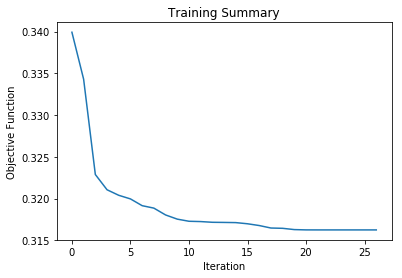

In [30]:
plot_iterations(log_reg_model.summary)

#### The AUC-ROC Curve

- AUC: Area Under The Curve
- ROC: Receiver Operating Characteristics
- TPR: True Positive Rate
- FPR: False Positive Rate

*AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. For example, the higher the AUC, the better the model is at distinguishing between patients with disease and no disease.  The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.* 

![AUC_ROC.png](AUC_ROC.png)

[Understanding AUC-ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)


- To query the area under the ROC curve to measure the model's performance:

In [31]:
log_reg_model.summary.areaUnderROC

0.6708001476259692

- and plot the ROC curve:

In [32]:
log_reg_model.summary.roc.show(5)

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|7.093342557917628E-4|0.009987981940429403|
| 0.09160906159936412| 0.27167310877967976|
|  0.0931132388979472| 0.27511612044044564|
| 0.09454745446171246| 0.27859161334329424|
+--------------------+--------------------+
only showing top 5 rows



In [33]:
def plot_roc_curve(summary):
  roc_curve = summary.roc.toPandas()
  plt.plot(roc_curve["FPR"], roc_curve["FPR"], "k")
  plt.plot(roc_curve["FPR"], roc_curve["TPR"])
  plt.title("ROC Area: %s" % summary.areaUnderROC)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.show()

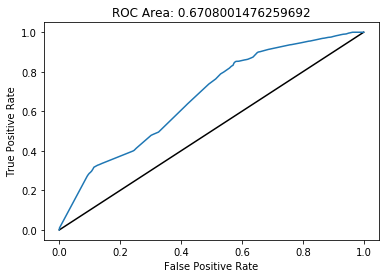

In [34]:
plot_roc_curve(log_reg_model.summary)

### Evaluate model performance on the test set.

- We have been assessing the model performance on the train DataFrame.  We really want to assess it on the test DataFrame.

- Method 1: Use the `evaluate` method of the `LogisticRegressionModel` class

In [35]:
test_summary = log_reg_model.evaluate(test)

- The result is an instance of the [BinaryLogisticRegressionSummary](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.BinaryLogisticRegressionSummary) class:

In [36]:
type(test_summary)

pyspark.ml.classification.BinaryLogisticRegressionSummary

- It has attributes similar to those of the `BinaryLogisticRegressionTrainingSummary` class:

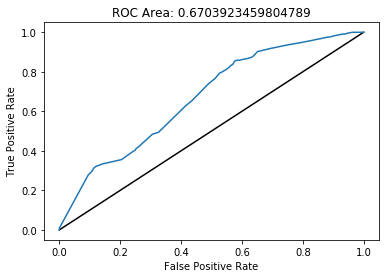

In [37]:
test_summary.areaUnderROC
plot_roc_curve(test_summary)

- Method 2: Use the `evaluate` method of the [BinaryClassificationEvaluator](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.BinaryClassificationEvaluator) class.

- Generate predictions on the test DataFrame:

In [38]:
test_with_prediction = log_reg_model.transform(test)
test_with_prediction.show(5)

+--------+----------------+------+--------------------+--------------------+--------------------+----------+
|SLA_days|dept_name_std_cd|target|            features|       rawPrediction|         probability|prediction|
+--------+----------------+------+--------------------+--------------------+--------------------+----------+
|    0.13|   (6,[2],[1.0])|     0|(7,[0,3],[0.13,1.0])|[1.00644630053892...|[0.73232410888562...|       0.0|
|    0.13|   (6,[2],[1.0])|     0|(7,[0,3],[0.13,1.0])|[1.00644630053892...|[0.73232410888562...|       0.0|
|    0.13|   (6,[2],[1.0])|     0|(7,[0,3],[0.13,1.0])|[1.00644630053892...|[0.73232410888562...|       0.0|
|    0.13|   (6,[2],[1.0])|     0|(7,[0,3],[0.13,1.0])|[1.00644630053892...|[0.73232410888562...|       0.0|
|    0.13|   (6,[2],[1.0])|     0|(7,[0,3],[0.13,1.0])|[1.00644630053892...|[0.73232410888562...|       0.0|
+--------+----------------+------+--------------------+--------------------+--------------------+----------+
only showing top 5 

- The resulting DataFrame includes three types of predictions.  The `rawPrediction` is a vector of log-odds, `prediction` is a vector or probabilities `prediction` is the predicted class based on the probability vector.

## Exercises

In the exercises we add another feature to the classification model and
determine if it improves the model performance.

1. Determine if `request_address_zip` is a promising feature.

2. Reassemble the feature vector and include `request_address_zip`.

3. Create new train and test datasets.

4. Refit the logistic regression model on the train dataset.

5. Apply the refit logistic model to the test dataset.

6. Compute the AUC on the test dataset.

## References

[Spark Documentation - Classification and regression](https://spark.apache.org/docs/latest/ml-classification-regression.html)

[Spark Python API - pyspark.ml.feature module](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml.feature)

[Spark Python API - pyspark.ml.classification module](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml.classification)

[Spark Python API - pyspark.ml.evaluation module](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml.evaluation)